In [83]:
import torch 
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import matplotlib.pyplot as plt 
from statistics import mean
import numpy as np
from google.colab import drive

In [64]:
if torch.cuda.is_available() :
  dev = torch.device('cuda:0')
else :
  dev = torch.device('cpu')

In [66]:
img_size = 100
t = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor()
])
data = ImageFolder('/content/drive/MyDrive/weather', transform=t)
labelmap = data.class_to_idx
num_classes = 4

print(data)
print(labelmap)


Dataset ImageFolder
    Number of datapoints: 1125
    Root location: /content/drive/MyDrive/weather
    StandardTransform
Transform: Compose(
               Resize(size=100, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(100, 100))
               ToTensor()
           )
{'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}


In [67]:
class NET(nn.Module):

    def __init__(self):
        super(NET,self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(6,6), stride=(2,2), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3,3), stride=1)
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=(2,2), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=1)
        )

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4,4), stride=(1,1), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.inshape = 128 * 21 * 21

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=self.inshape, out_features=200),
            nn.BatchNorm1d(200),
            nn.ReLU6()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(in_features=200, out_features=100),
            nn.BatchNorm1d(100),
            nn.ReLU6()
        )

        self.out_layer = nn.Linear(in_features=100, out_features=num_classes)

    def forward(self,x):

        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)

        #print(x.shape)
        x = x.reshape(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])

        x = self.fc1(x)
        x = self.fc2(x)
        return self.out_layer(x)

In [68]:
model = NET()
model.to(torch.device(dev))

NET(
  (convblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(3, 3), stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (convblock3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc1): Sequential(
    (0): Linear(in_features=56448, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (

In [69]:
batch_size = 50
epochs = 30
lr = 0.005
momentum = 0.8
dataset_size = 1125
show_every = 2

loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(params=model.parameters(), lr=lr, momentum=momentum)
#opt = optim.Adam(params=model.parameters(), lr = lr)

loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=True)

acc_list = []
loss_list = []
mean_loss_list = []
num_batches = int(dataset_size/batch_size)
print(f'{num_batches} batches per epoch.')

for epoch in range(epochs):

    batch_counter = 0
    correct, incorrect = 0,0
    temp_loss = []

    for x,y in loader :

        x = x.to(dev)
        y = y.to(dev)
        opt.zero_grad()
        yhat = model.forward(x)
        loss = loss_fn(yhat,y)
        loss.backward()
        opt.step()

        loss_list.append(loss.item())
        temp_loss.append(loss.item())

        for i in range(len(yhat)):
            if torch.argmax(yhat[i]) == y[i]:
                correct += 1
            else :
                incorrect += 1

        if batch_counter % show_every == 0 :
            print(f'{batch_counter} --> ', end='', flush=True)

        batch_counter += 1

    acc = (correct / (correct + incorrect)) * 100
    acc_list.append(acc)

    mean_loss = mean(temp_loss)
    mean_loss_list.append(mean_loss)

    print()
    print(f'Epoch : {epoch} | Loss : {mean_loss} | Accuracy : {acc}')
    print('-' * 50)

22 batches per epoch.
0 --> 2 --> 4 --> 6 --> 8 --> 10 --> 12 --> 14 --> 16 --> 18 --> 20 --> 22 --> 
Epoch : 0 | Loss : 0.5936029501583265 | Accuracy : 79.91111111111111
--------------------------------------------------
0 --> 2 --> 4 --> 6 --> 8 --> 10 --> 12 --> 14 --> 16 --> 18 --> 20 --> 22 --> 
Epoch : 1 | Loss : 0.3167952493481014 | Accuracy : 89.77777777777777
--------------------------------------------------
0 --> 2 --> 4 --> 6 --> 8 --> 10 --> 12 --> 14 --> 16 --> 18 --> 20 --> 22 --> 
Epoch : 2 | Loss : 0.2383558821419011 | Accuracy : 92.80000000000001
--------------------------------------------------
0 --> 2 --> 4 --> 6 --> 8 --> 10 --> 12 --> 14 --> 16 --> 18 --> 20 --> 22 --> 
Epoch : 3 | Loss : 0.18259536118611044 | Accuracy : 95.55555555555556
--------------------------------------------------
0 --> 2 --> 4 --> 6 --> 8 --> 10 --> 12 --> 14 --> 16 --> 18 --> 20 --> 22 --> 
Epoch : 4 | Loss : 0.17671757288601087 | Accuracy : 94.93333333333334
---------------------------

In [70]:
def plot_metric(metric, title, ax_to_plot):
    ax_to_plot.set_title(title)
    ax_to_plot.plot(metric, linewidth = 3)
    ax_to_plot.grid(True)

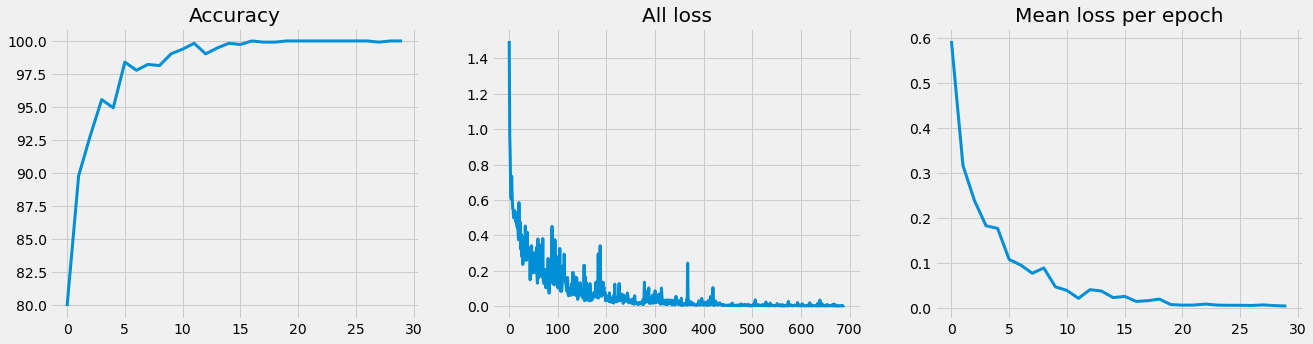

In [71]:
plt.style.use('fivethirtyeight')
fig,ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20,5))

plot_metric(acc_list, 'Accuracy', ax[0])
plot_metric(loss_list, 'All loss', ax[1])
plot_metric(mean_loss_list, 'Mean loss per epoch', ax[2])

In [116]:
#torch.save(model.state_dict(), '/content/drive/MyDrive/model_dict.pt')
"""
To load on CPU :

dev = torch.device('cpu')
model = ModelClass()
model.load_state_dict(torch.load(PATH, map_location = dev))

"""

In [112]:
def plot_samples(data,model):
  model.eval()
  temp_labelmap = data.class_to_idx
  labelmap = {y:x for x,y in temp_labelmap.items()}

  fix,ax = plt.subplots(nrows = 4, ncols = 5, figsize = (20,16))
  ax = ax.flatten()

  random_images = np.random.randint(0,1125, size = 20)
  counter = 0

  for i in random_images:
    x,y = data[i]
    true_label = labelmap[y]
    img = transforms.ToPILImage()(x)

    ax[counter].imshow(img)
    ax[counter].axis(False)

    model_input = x.to(dev)
    output = torch.argmax(model.forward(torch.unsqueeze(model_input,0)))
    output_label = labelmap[output.item()]

    caption = f'True : {true_label} | Pred : {output_label}'
    ax[counter].set_title(caption, size = 15)
    
    counter += 1

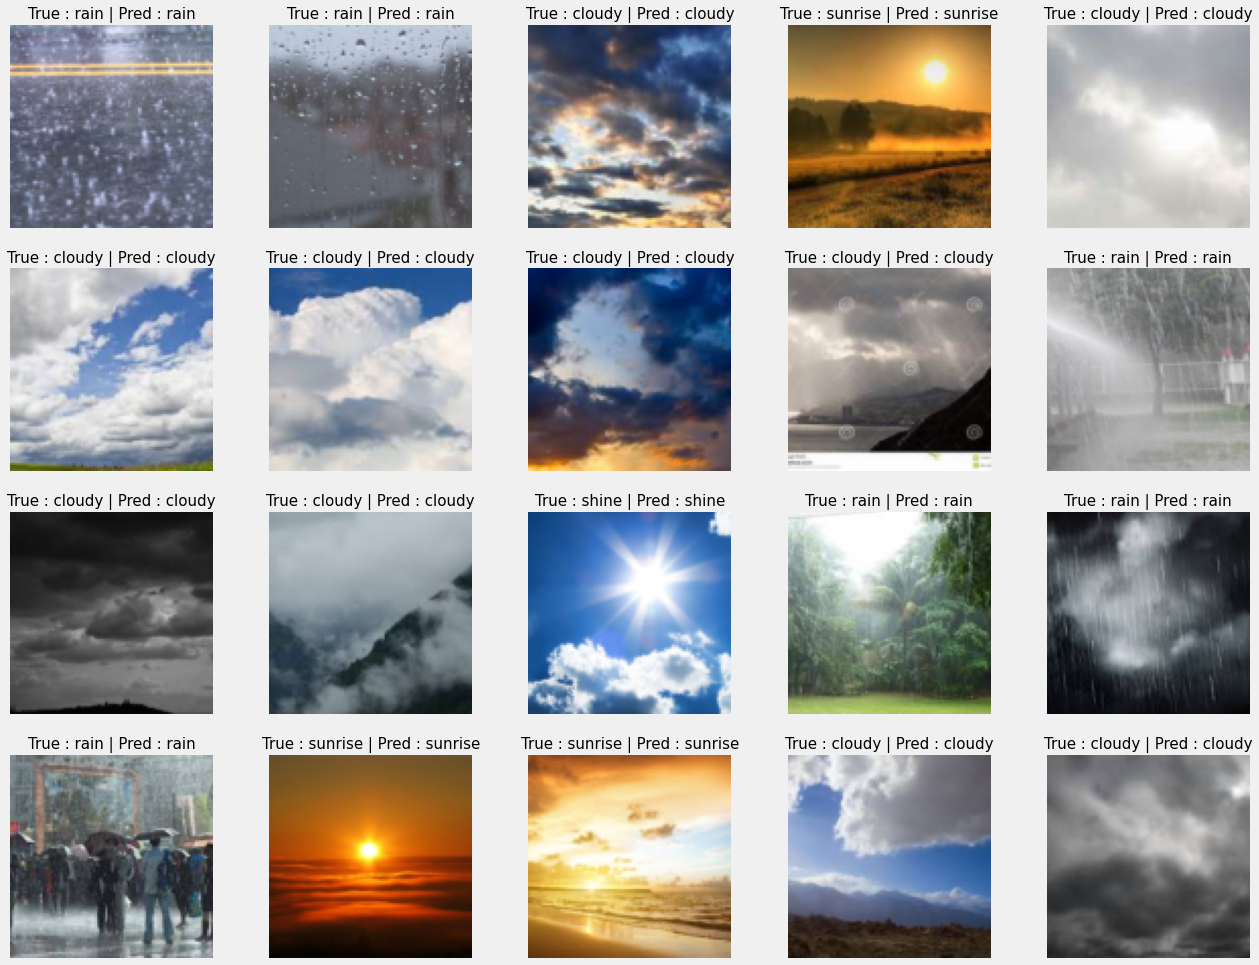

In [113]:
plot_samples(data,model)